# Hateful Memes Detection
![Mean memes from https://ai.facebook.com/blog/hateful-memes-challenge-and-data-set](images/facebook_mean_memes.png)
Photo from [Facebook AI](https://ai.facebook.com/blog/hateful-memes-challenge-and-data-set). These are examples of "mean" memes, not actual hateful memes, which would be distasteful to display.

## Overview

Moderating online content, particularly the multimodal combination of text and images in the form of memes, is an extensive and difficult problem for social media and society. This project uses a curated dataset of memes from Facebook AI to detect whether a meme is hateful based on its textual content. The final model is a bag-of-words model vectorized by word counts. This model accurately classifies 61% of memes, with an ROC-AUC of 0.578. The model could be used as part of a hateful meme detection system to tag content with potentially hateful memes with a warning and blurred image, or even to automatically remove content with memes predicted as hateful.

## Business Problem

Online content moderation is a difficult problem for social media with substantial effects on society. One aspect of content moderation is the moderation of online hate speech. To get an understanding of the scope of this problem, let's take a look at Facebook's quarterly community standards enforcement report.

The [section of the report on hate speech](https://transparency.fb.com/data/community-standards-enforcement/hate-speech/facebook/) shows that over the first 3 quarters of 2021, Facebook took action against 79 million pieces of hate speech content, of which 1.2 million was restored due to mistakes. In addition, Facebook estimates that 3-6 out of every 10,000 views of content violated their hate speech community standards. So much content could never be moderated via only manual human inspection, and indeed, [Facebook deploys automated solutions](https://about.fb.com/news/2021/11/community-standards-enforcement-report-q3-2021/) as part of their full approach to content moderation as seen in the "How We Reduce Harmful Content People See on Our Apps" section near the bottom of the linked 
article. It is assumed that for any social media site with user-generated content, this two-pronged approach of automated and manual solutions will be crucial.

One particularly challenging type of content to moderate are memes. Memes are multimodal, as their content is both textual and visual. The semantic interpretation of a meme depends upon each of these components and their interaction. For this project, I will be beginning the work of classifying memes as hateful or not by taking a look at the meme text only. As indicated in the [Conclusion's future work subsection](#future_work), a goal of mine is to incorporate the visual content into a multimodal model at a later date.

The stakeholders for this work would be any business needing an automated solution to their online content moderation efforts. The narrow focus would be moderating memes for their hate speech content. The model produced by this work could be used to infer whether a meme is hateful. This prediction could inform a content moderation strategy, such as automatically removing content with a meme predicted to be hateful.

The quality of predictions are important as both false positives and false negatives have serious consequences. In this context, a false positive would be predicting a meme to be hateful when it isn't. Taking action against such content, like removing it, would likely frustrate users and could lead to user churn. A false negative would be predicting a meme to not be hateful when in fact it is. Not acting on such truly hateful memes is a failure to moderate hate speech and would violate a community's standards.

Thus, distinguishing between hateful and not hateful memes is a priority for the model, and the metrics to focus on optimizing will be accuracy, f1 score, and area under the ROC (ROC-AUC).

## Data Understanding

Facebook AI has curated a dataset of memes which will be used as the dataset for this project. These memes have a binary classification label of hateful or not-hateful, which is suitable for the goal of building a model to predict whether a meme is hateful.

For complete details on the curation of the dataset, see this [paper](https://arxiv.org/pdf/2005.04790.pdf). A high-level summary is provided below.

Facebook AI used third-party annotators for the manual curation of the dataset. A source dataset of more than 1 million images from social media sites in the United States was filtered down to 46k candidate memes by removing non-meme images, duplicates, non-English-text memes, and memes with violating content.

Next, the images for these candidate memes were replaced for licensing purposes. Suitable substitute images were obtained in partnership with Getty Images, and the meme was reconstructed to maintain its semantic content. Memes without such substitute images were discarded.

Then, the memes were given a hatefulness rating by a group of annotators. The definition of hate speech used was:

> A direct or indirect attack on people based on characteristics, including ethnicity, race, nationality, immigration status, religion, caste, sex, gender identity, sexual orientation, and disability or disease. We define attack as violent or dehumanizing (comparing people to non-human things, e.g. animals) speech, statements of inferiority, and calls for exclusion or segregation. Mocking hate crime is also considered hate speech.

The rating was a ternary indicator with an unsure option for hatefulness. The ternary rating was transformed to a binary label of hateful or not-hateful. Memes with severe disagreement in the rating were reviewed and labeled by an expert.

Finally, for those memes labeled as hateful, benign confounders were created. Benign confounders replace either the image or the text to flip the label from hateful to not-hateful. Benign confounders could not be created for all hateful memes if in fact the meme was unimodally hateful because of its text, image, or both.

The data can be retrieved following the instructions found in the README of this project's [repository on GitHub](https://github.com/andrewwhitman/HatefulMemesDetection#Reproducibility).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from utils import evaluate, generate_glove, strip_punctuation, W2vTokenizer, W2vVectorizer

pd.set_option('display.max_columns', None)
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

The dataset of memes comes in the form of image files and json lines files with pre-extracted text, so optical character recognition is not needed to extract text from the meme images.

In [2]:
# load the jsonl files
train_df = pd.read_json('data/raw/train.jsonl', lines=True, )
dev_seen_df = pd.read_json('data/raw/dev_seen.jsonl', lines=True)
dev_unseen_df = pd.read_json('data/raw/dev_unseen.jsonl', lines=True)
test_seen_df = pd.read_json('data/raw/test_seen.jsonl', lines=True)
test_unseen_df = pd.read_json('data/raw/test_unseen.jsonl', lines=True)

In [3]:
# dict to help inspect each df
df_dict = {'train': train_df,
           'dev_seen': dev_seen_df,
           'dev_unseen': dev_unseen_df,
           'test_seen': test_seen_df,
           'test_unseen':test_unseen_df
          }

# inspect each df
ids = []
for name, df in df_dict.items():
    print(name.upper())
    df.info()
    print(f"\nThe target distribution for {name} is: \n{df['label'].value_counts()}")
    print('\n')
    ids.extend(df['id'])

TRAIN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      8500 non-null   int64 
 1   img     8500 non-null   object
 2   label   8500 non-null   int64 
 3   text    8500 non-null   object
dtypes: int64(2), object(2)
memory usage: 265.8+ KB

The target distribution for train is: 
0    5481
1    3019
Name: label, dtype: int64


DEV_SEEN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      500 non-null    int64 
 1   img     500 non-null    object
 2   label   500 non-null    int64 
 3   text    500 non-null    object
dtypes: int64(2), object(2)
memory usage: 15.8+ KB

The target distribution for dev_seen is: 
0    253
1    247
Name: label, dtype: int64


DEV_UNSEEN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54

In [4]:
# take a look
train_df.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


Each meme has an `id`, an `img` file name, a `label`, and pre-extracted `text`. There are five splits in accordance with the [competition](https://www.drivendata.org/competitions/64/hateful-memes/page/205/) associated with the dataset. The target is relatively balanced in the development and test sets, less so in the train set. For this project, these will be condensed to three splits, one for training, one for model validation or testing, and a holdout set for evaluation of the final model. Before creating these splits, let's ensure there are no duplicate memes in the dataset.

In [5]:
# are there any duplicate ids?
try:
    assert(len(ids) == len(set(ids)))
except:
    print(f'There are {len(set(ids))} unique ids out of {len(ids)} total ids.')

There are 12140 unique ids out of 12540 total ids.


In [6]:
# here are the 400 dupes
len(set(dev_unseen_df['id']).intersection(set(dev_seen_df['id'])))

400

The duplicate memes are in the seen and unseen development sets. We'll remove these when we make the splits now. We'll split according to:
1. train set - the same as provided
2. test set - combination of the unique memes from the two development sets and the seen test set
3. holdout set - the unseen test set

In [7]:
# create train set
train_df = train_df.set_index('id')

# test set
test_df = pd.concat([dev_seen_df, dev_unseen_df, test_seen_df])
test_df = test_df.drop_duplicates(subset='id')
test_df = test_df.set_index('id')

# holdout set
hold_df = test_unseen_df.set_index('id')

In [8]:
# confirm number of memes
ids = list(train_df.index) + list(test_df.index) + list(hold_df.index)
assert(len(ids) == len(set(ids)))

# display train, test, holdout sizes
print(f"There are {len(ids):,} memes.")
print(f"Train size:\t{len(train_df) / len(ids):.2%}")
print(f"Test size:\t{len(test_df) / len(ids):.2%}")
print(f"Holdout size:\t{len(hold_df) / len(ids):.2%}")

There are 12,140 memes.
Train size:	70.02%
Test size:	13.51%
Holdout size:	16.47%


In [9]:
# create X, y
X_train, X_test, X_hold = train_df['text'], test_df['text'], hold_df['text']
y_train, y_test, y_hold = train_df['label'], test_df['label'], hold_df['label']

## Data Preparation

When working with text data, there are many preparation decisions that have to be made. This section will discuss these decisions, and the next section will implement the preparation steps in a pipeline for consistent use in the modeling process. The choice of preparation steps should be informed by the business problem and modeling approaches.

The two overarching questions to consider are:
1. How should the text be tokenized?
2. How should the text be vectorized?

These questions are not necessarily answered sequentially, as their choices affect one another. For example, if GloVe vectors are used to vectorize text, then care should be taken to tokenize text in a way which comforms to the tokenization strategy employed in the creation of GloVe vectors. The ideal case uses the exact same tokenization strategy. Unfortunately, this tokenization strategy is not always clearly documented, in which case trial-and-error tokenization is performed.

The first set of models for this project uses the bag-of-words approach. The preparation choices are:

- Stop word removal is another choice which affects the tokenization strategy. If the text is tokenized in a way inconsistent with the tokenization strategy of the stop word list, then there will be inconsistent removal of tokens. See this [paper](https://aclanthology.org/W18-2502.pdf) for a thorough discussion of the issues surrounding open-source software stop lists. Because of this, stop words will be handled as follows:
    1. The use of scikit-learn's stop list is a hyperparameter to be grid searched.
    2. The `max_df` hyperparameter of scikit-learn's vectorizers is grid searched. In effect, this creates corpus-specific stop words.


- Tokens are defined according to scikit-learn's vectorizers. Tokens are 2 or more alphanumeric characters, disregarding all punctuation.
- Tokens are neither stemmed nor lemmatized. Since this project is using text from memes, the number of tokens in each meme is relatively small compared to other possible text documents. Instead of reducing the vocabulary size this way, the `max_features` hyperparameter of scikit-learn's vectorizers is grid searched. This limits the vocabulary to the most used tokens throughout the corpus.
- The use of unigrams and bigrams are grid searched using the `ngram_range` hyperparameter.
- The bag-of-words models use count, boolean, or tf-idf vectorization.

GloVe embeddings are used for the second set of models. The preparation choices are:
- A stop word list is not used. But, a token is only included if it has a corresponding GloVe embedding.
- Tokens are generated using NLTK's `word_tokenize` function, which includes punctuation. An additional step to strip leading and trailing punctuation is applied to approximate the tokenization strategy used for GloVe embeddings.
- Since GloVe tokens have not been stemmed or lemmatized, neither is applied.
- The entire vocabulary is used, but the embeddings for the tokens of a meme are averaged to create a mean embedding vector for each meme.

### GloVe Word Embeddings

Before moving on to modeling and evaluation, let's generate the GloVe vectors which will be used to vectorize the text. The GloVe vectors can be retrieved following the instructions found in the README of this project's [repository on GitHub](https://github.com/andrewwhitman/HatefulMemesDetection#Reproducibility). We will be using 300-dimensional word embeddings.

In [10]:
# tokenize the meme text
X_train_token = X_train.map(word_tokenize)

# unique tokens in training set
vocabulary = set(token for meme in X_train_token for token in meme)

# vocabulary size
len(vocabulary)

9178

In [11]:
# generate GloVe embeddings for the corpus vocab
glove = generate_glove(vocabulary)

# proportion of vocab with GloVe embedding
print(f'Found embeddings for {len(glove)/len(vocabulary):.2%} of vocabulary')

# which tokens don't have GloVe embeddings
missing_embeddings = sorted(list(vocabulary.difference(set(glove))))
missing_embeddings[:20]

Found embeddings for 89.54% of vocabulary


["''did",
 "''dont",
 "''oh",
 "'ahly",
 "'bigoted",
 "'bout",
 "'cruising",
 "'dark",
 "'dog",
 "'donnell",
 "'eliminate",
 "'first",
 "'guess",
 "'just",
 "'load",
 "'macho",
 "'nationalism",
 "'negotiate'with",
 "'palestinian",
 "'peaceful"]

As discussed above, some leading and trailing punctuation still needs removed from some words to get the GloVe vectors. We'll do that below.

In [12]:
# strip tokens without an embedding of punctuation
X_train_token = X_train_token.map(lambda x: list(strip_punctuation(x, glove)))

# unique tokens in training set
vocabulary = set(token for meme in X_train_token for token in meme)

# vocabulary size
len(vocabulary)

9098

In [13]:
# generate GloVe embeddings again
glove = generate_glove(vocabulary)

# proportion of vocab with GloVe embedding
print(f'Found embeddings for {len(glove)/len(vocabulary):.2%} of vocabulary')

# which tokens don't have GloVe embeddings
missing_embeddings = sorted(list(vocabulary.difference(set(glove))))
missing_embeddings[:20]

Found embeddings for 90.55% of vocabulary


['',
 '01/08/19',
 '0mar',
 '1-800-abos-r-dum',
 '1-800-you-lost',
 '1-866-347-2423',
 '1/1024th',
 '1024/1024th',
 '10\\10',
 '12:30pm',
 '1400/wk',
 '154km',
 '157,876',
 '159cm',
 '15august1947',
 '169cm',
 '1:8-9',
 '2+2',
 '2014and',
 '21:33']

The GloVe vectors have now been loaded into memory and will be used to vectorize the memes in a pipeline.

## Modeling and Evaluation

Before making a first model, let's check the distribution of the target in the train set again.

### Dummy Baseline

In [14]:
# training data base rate
y_train.value_counts(normalize=True)

0    0.644824
1    0.355176
Name: label, dtype: float64

We can use this base rate to make a baseline prediction.

In [15]:
# baseline prediction of predicting hateful meme at the base rate found in the train set
dummy = DummyClassifier(strategy='stratified', random_state=42)

# fit on train 
dummy.fit(X_train, y_train)

DummyClassifier(random_state=42, strategy='stratified')

All models will be evaluated based on the following custom function. It calculates metrics for training and testing data, along with showing the confusion matrix and ROC plot. Accuracy, f1, and ROC-AUC will be prioritized.

Training Metrics
Accuracy: 0.539
Precision: 0.347
Recall: 0.339
f1: 0.343
----------
Testing Metrics
Accuracy: 0.526
Precision: 0.466
Recall: 0.368
f1: 0.411


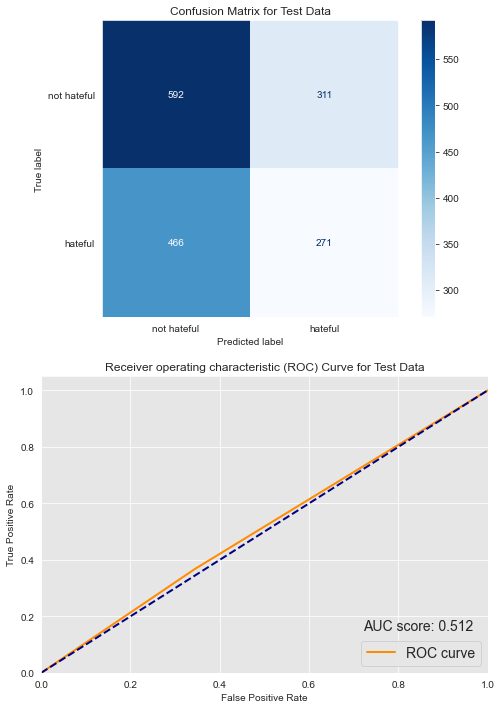

In [16]:
# evaluate model on train and test
evaluate(dummy, X_train, y_train, X_test, y_test)

Though not really a model, we can still generate metrics to see how our base rate guesses would turn out. We'll see if our modeling process improves on an accuracy of 52.6%, f1 score of 0.411, and by definition an ROC-AUC near 0.5 or random guessing.

### Bag of Words - Count Vectorization

The first simple model will vectorize the meme text into word counts and then fit a multinomial Naive Bayes classifier, which is lightweight and efficient for a bag-of-words approach.

In [17]:
# pipeline of vectorizer and classifier
count_mnb = Pipeline([('vect', CountVectorizer()),
                      ('clf', MultinomialNB())])

# fit on train
count_mnb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('clf', MultinomialNB())])

Training Metrics
Accuracy: 0.824
Precision: 0.790
Recall: 0.685
f1: 0.734
----------
Testing Metrics
Accuracy: 0.591
Precision: 0.575
Recall: 0.343
f1: 0.430


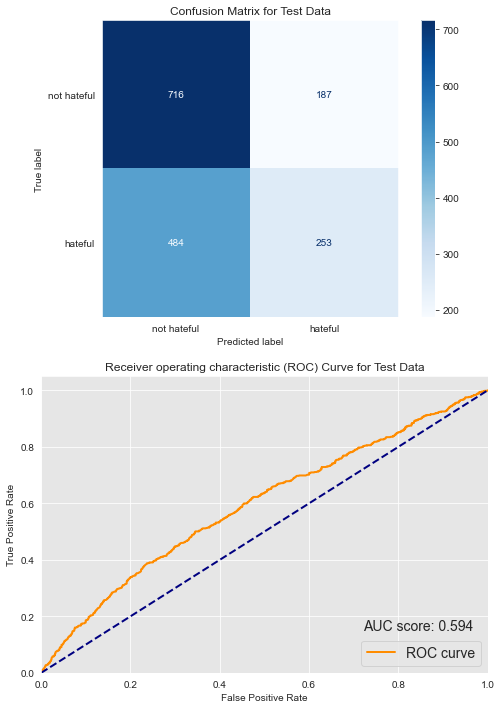

In [18]:
# evaluate model on train and test
evaluate(count_mnb, X_train, y_train, X_test, y_test)

This first simple model improves on the baseline in all three relevant metrics. It does appear to be overfitting to the train set based on the divergence in training and testing metrics. We can apply more preprocessing steps as described in the previous section using a grid search approach. First, let's see the vocabulary size.

In [19]:
# vocabulary size
len(count_mnb['vect'].vocabulary_)

8853

With this vocabulary size, let's grid search over the `max_features` hyperparameter in addition to the other vectorizer hyperparameters. We'll also see if the MNB model's smoothing hyperparameter, `alpha`, could be tuned.

In [20]:
# relevant scoring metrics
scoring_metrics = ('accuracy', 'f1', 'roc_auc')

In [21]:
# parameter grid
count_grid = {
    "vect__max_df": (0.5, 0.25, 0.1,),
    'vect__max_features': (None, 2000, 4000),
    "vect__ngram_range": ((1, 1), (1, 2)),
    "vect__stop_words": (None, 'english'),
    "clf__alpha": (1, 0.1),
}

# refit on roc_auc
count_gs = GridSearchCV(estimator=count_mnb, param_grid=count_grid, scoring=scoring_metrics, refit='roc_auc', n_jobs=-1)

# fit on train
count_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': (1, 0.1),
                         'vect__max_df': (0.5, 0.25, 0.1),
                         'vect__max_features': (None, 2000, 4000),
                         'vect__ngram_range': ((1, 1), (1, 2)),
                         'vect__stop_words': (None, 'english')},
             refit='roc_auc', scoring=('accuracy', 'f1', 'roc_auc'))

Training Metrics
Accuracy: 0.767
Precision: 0.703
Recall: 0.597
f1: 0.646
----------
Testing Metrics
Accuracy: 0.598
Precision: 0.585
Recall: 0.365
f1: 0.449

Best Parameters
{'clf__alpha': 1, 'vect__max_df': 0.25, 'vect__max_features': 2000, 'vect__ngram_range': (1, 1), 'vect__stop_words': None}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,param_vect__max_df,param_vect__max_features,param_vect__ngram_range,param_vect__stop_words,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
16,0.192409,0.005307,0.087487,7.659857e-03,1,0.25,2000,"(1, 1)",None,"{'clf__alpha': 1, 'vect__max_df': 0.25, 'vect_...",0.713529,0.658824,0.686471,0.682353,0.718235,0.691882,0.021799,17,0.551152,0.471767,0.508756,0.506399,0.573464,0.522307,0.035889,46,0.716463,0.671462,0.693277,0.699577,0.730740,0.702304,0.020245,1
28,0.204232,0.014613,0.088915,1.140937e-02,1,0.1,2000,"(1, 1)",None,"{'clf__alpha': 1, 'vect__max_df': 0.1, 'vect__...",0.712353,0.660588,0.690588,0.684706,0.710588,0.691765,0.018981,18,0.550964,0.478771,0.515654,0.509158,0.565371,0.523984,0.030901,41,0.716412,0.671851,0.695928,0.695683,0.731382,0.702251,0.020280,2
4,0.194338,0.014504,0.086706,9.640574e-03,1,0.5,2000,"(1, 1)",None,"{'clf__alpha': 1, 'vect__max_df': 0.5, 'vect__...",0.712941,0.663529,0.683529,0.685882,0.715882,0.692353,0.019637,16,0.552294,0.479053,0.506422,0.514545,0.569902,0.524443,0.032635,39,0.720067,0.669204,0.694798,0.694303,0.729299,0.701534,0.021247,3
17,0.168709,0.006247,0.092959,4.267687e-03,1,0.25,2000,"(1, 1)",english,"{'clf__alpha': 1, 'vect__max_df': 0.25, 'vect_...",0.718824,0.664118,0.688235,0.687059,0.704706,0.692588,0.018413,12,0.567812,0.490633,0.514652,0.515483,0.555752,0.528866,0.028575,15,0.713720,0.673423,0.692264,0.697899,0.729506,0.701362,0.019079,4
5,0.192205,0.010829,0.085632,1.033355e-02,1,0.5,2000,"(1, 1)",english,"{'clf__alpha': 1, 'vect__max_df': 0.5, 'vect__...",0.718824,0.664118,0.688235,0.687059,0.704706,0.692588,0.018413,12,0.567812,0.490633,0.514652,0.515483,0.555752,0.528866,0.028575,15,0.713720,0.673423,0.692264,0.697899,0.729506,0.701362,0.019079,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,0.386137,0.023745,0.124969,6.031566e-07,0.1,0.25,None,"(1, 2)",english,"{'clf__alpha': 0.1, 'vect__max_df': 0.25, 'vec...",0.633529,0.631176,0.635294,0.620588,0.651176,0.634353,0.009840,67,0.515175,0.514330,0.509494,0.482759,0.533438,0.511039,0.016321,58,0.625151,0.610827,0.616557,0.607384,0.642193,0.620422,0.012436,67
39,0.426092,0.021404,0.131453,1.604584e-02,0.1,0.5,None,"(1, 2)",english,"{'clf__alpha': 0.1, 'vect__max_df': 0.5, 'vect...",0.633529,0.631176,0.635294,0.620588,0.651176,0.634353,0.009840,67,0.515175,0.514330,0.509494,0.482759,0.533438,0.511039,0.016321,58,0.625151,0.610827,0.616557,0.607384,0.642193,0.620422,0.012436,67
38,0.576602,0.013294,0.180978,3.098648e-02,0.1,0.5,None,"(1, 2)",None,"{'clf__alpha': 0.1, 'vect__max_df': 0.5, 'vect...",0.639412,0.624706,0.631765,0.612353,0.629412,0.627529,0.008955,71,0.519216,0.485484,0.495974,0.468119,0.503937,0.494546,0.017201,69,0.627859,0.606055,0.617266,0.605621,0.627678,0.616896,0.009810,70
50,0.542706,0.021190,0.162459,7.652942e-03,0.1,0.25,None,"(1, 2)",None,"{'clf__alpha': 0.1, 'vect__max_df': 0.25, 'vec...",0.638235,0.625882,0.632941,0.610000,0.629412,0.627294,0.009562,72,0.519156,0.487923,0.497585,0.465753,0.503937,0.494871,0.017751,68,0.627410,0.605972,0.617072,0.605707,0.627406,0.616713,0.009648,71


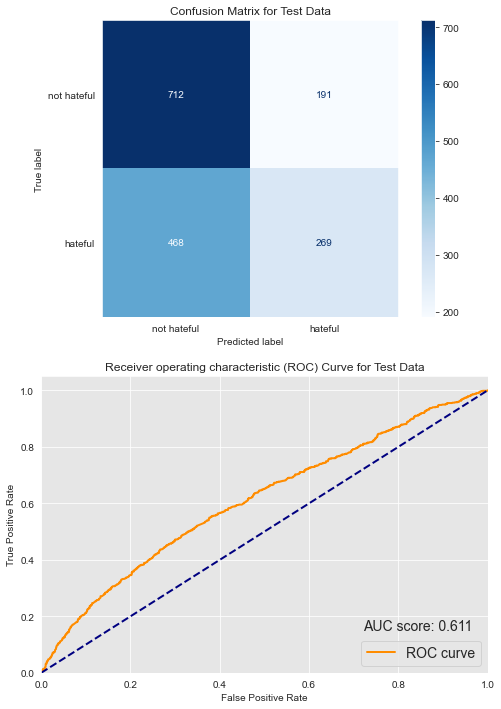

In [22]:
# evaluate model on train and test
evaluate(count_gs, X_train, y_train, X_test, y_test, grid_search=True)

This tuned multinomial Naive Bayes classifier based on count vectorization has improved on the first simple model. Testing accuracy is 59.8% compared 59.1%, testing f1 score is 0.449 compared to 0.430, and ROC-AUC is 0.611 compared to 0.594. These are marginal improvements, yet still improvements. This model uses the 2000 most frequent unigram tokens which appear in at most 25% of the documents as its vocabulary. Stop words are not removed using scikit-learn's stop list. This tuned classifier also appears less overfit than the simple model when comparing each of their training metrics to their testing metrics.

### Bag of Words - Boolean Vectorization

Instead of vectorizing to word counts, let's see if an even simpler model which indicates only if the meme text has a token or not can perform better. With such short text phrases, this may be better. One difference is we'll now use a Bernoulli Naive Bayes classifier since the data is either a "1" or "0" for each token in the vocabulary.

In [23]:
# pipeline of vectorizer and classifier
bool_bnb = Pipeline([('vect', CountVectorizer(binary=True)),
                     ('clf', BernoulliNB())])

In [24]:
# parameter grid
bool_grid = {
    "vect__max_df": (0.5, 0.25, 0.1),
    'vect__max_features': (None, 2000, 4000),
    "vect__ngram_range": ((1, 1), (1, 2)),
    "vect__stop_words": (None, 'english'),
    "clf__alpha": (1, 0.1),
}

# refit on roc_auc
bool_gs = GridSearchCV(estimator=bool_bnb, param_grid=bool_grid, scoring=scoring_metrics, refit='roc_auc', n_jobs=-1)

# fit on train
bool_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vect', CountVectorizer(binary=True)),
                                       ('clf', BernoulliNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': (1, 0.1),
                         'vect__max_df': (0.5, 0.25, 0.1),
                         'vect__max_features': (None, 2000, 4000),
                         'vect__ngram_range': ((1, 1), (1, 2)),
                         'vect__stop_words': (None, 'english')},
             refit='roc_auc', scoring=('accuracy', 'f1', 'roc_auc'))

Training Metrics
Accuracy: 0.777
Precision: 0.758
Recall: 0.547
f1: 0.636
----------
Testing Metrics
Accuracy: 0.599
Precision: 0.648
Recall: 0.237
f1: 0.348

Best Parameters
{'clf__alpha': 1, 'vect__max_df': 0.5, 'vect__max_features': 2000, 'vect__ngram_range': (1, 2), 'vect__stop_words': 'english'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,param_vect__max_df,param_vect__max_features,param_vect__ngram_range,param_vect__stop_words,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
19,0.374238,0.018720,0.132728,0.004912,1,0.25,2000,"(1, 2)",english,"{'clf__alpha': 1, 'vect__max_df': 0.25, 'vect_...",0.741765,0.708824,0.715294,0.720000,0.737647,0.724706,0.012818,1,0.556117,0.494382,0.508130,0.515275,0.552209,0.525223,0.024597,33,0.751305,0.705895,0.722703,0.725323,0.752641,0.731573,0.017946,1
31,0.437388,0.024304,0.164519,0.014433,1,0.1,2000,"(1, 2)",english,"{'clf__alpha': 1, 'vect__max_df': 0.1, 'vect__...",0.741765,0.708824,0.715294,0.720000,0.737647,0.724706,0.012818,1,0.556117,0.494382,0.508130,0.515275,0.552209,0.525223,0.024597,33,0.751305,0.705895,0.722703,0.725323,0.752641,0.731573,0.017946,1
7,0.499865,0.050766,0.132445,0.004567,1,0.5,2000,"(1, 2)",english,"{'clf__alpha': 1, 'vect__max_df': 0.5, 'vect__...",0.741765,0.708824,0.715294,0.720000,0.737647,0.724706,0.012818,1,0.556117,0.494382,0.508130,0.515275,0.552209,0.525223,0.024597,33,0.751305,0.705895,0.722703,0.725323,0.752641,0.731573,0.017946,1
29,0.204053,0.008311,0.096741,0.004232,1,0.1,2000,"(1, 1)",english,"{'clf__alpha': 1, 'vect__max_df': 0.1, 'vect__...",0.732353,0.703529,0.713529,0.708824,0.728235,0.717294,0.011152,7,0.556962,0.498008,0.516385,0.503511,0.560000,0.526973,0.026426,29,0.747736,0.706410,0.716106,0.724640,0.752792,0.729537,0.017951,4
17,0.190229,0.007965,0.096366,0.006222,1,0.25,2000,"(1, 1)",english,"{'clf__alpha': 1, 'vect__max_df': 0.25, 'vect_...",0.732353,0.703529,0.713529,0.708824,0.728235,0.717294,0.011152,7,0.556962,0.498008,0.516385,0.503511,0.560000,0.526973,0.026426,29,0.747736,0.706410,0.716106,0.724640,0.752792,0.729537,0.017951,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,0.492181,0.021187,0.151360,0.007197,0.1,0.1,None,"(1, 2)",english,"{'clf__alpha': 0.1, 'vect__max_df': 0.1, 'vect...",0.667647,0.665294,0.666471,0.647647,0.678235,0.665059,0.009854,67,0.489612,0.479414,0.491480,0.445883,0.500457,0.481369,0.018961,55,0.643740,0.623282,0.631021,0.618408,0.657514,0.634793,0.014223,67
39,0.407709,0.011396,0.155185,0.016420,0.1,0.5,None,"(1, 2)",english,"{'clf__alpha': 0.1, 'vect__max_df': 0.5, 'vect...",0.667647,0.665294,0.666471,0.647647,0.678235,0.665059,0.009854,67,0.489612,0.479414,0.491480,0.445883,0.500457,0.481369,0.018961,55,0.643740,0.623282,0.631021,0.618408,0.657514,0.634793,0.014223,67
38,0.626922,0.049925,0.234773,0.036067,0.1,0.5,None,"(1, 2)",None,"{'clf__alpha': 0.1, 'vect__max_df': 0.5, 'vect...",0.665882,0.658235,0.655882,0.637647,0.664706,0.656471,0.010141,70,0.505226,0.461538,0.481842,0.444043,0.502618,0.479054,0.023582,58,0.640322,0.618889,0.625072,0.616456,0.640664,0.628281,0.010360,70
50,0.678186,0.078725,0.220610,0.018231,0.1,0.25,None,"(1, 2)",None,"{'clf__alpha': 0.1, 'vect__max_df': 0.25, 'vec...",0.665294,0.657647,0.654118,0.637647,0.665294,0.656000,0.010157,71,0.504787,0.461111,0.479646,0.441016,0.503923,0.478097,0.024679,59,0.640076,0.618862,0.625083,0.616550,0.640485,0.628211,0.010243,71


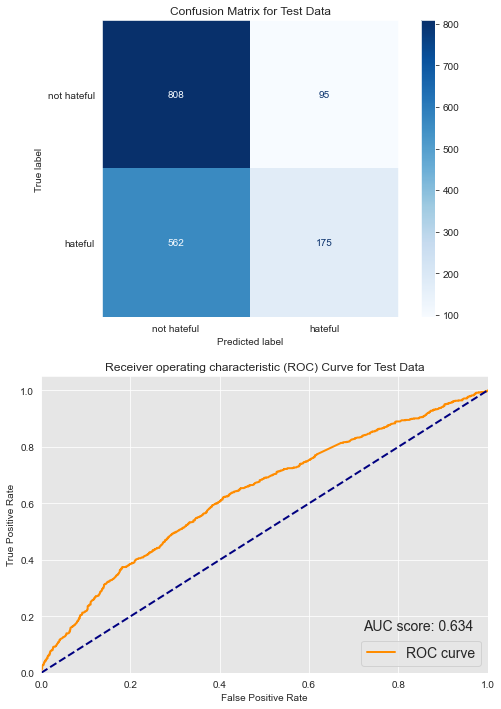

In [25]:
# evaluate model on train and test
evaluate(bool_gs, X_train, y_train, X_test, y_test, grid_search=True)

This tuned Bernoulli Naive Bayes classifier based on boolean vectorization is comparable in some respects to the tuned multinomial Naive Bayes classifier based on count vectorization. Testing accuracy is 59.9% compared 59.8%, testing f1 score is 0.348 compared to 0.449, and ROC-AUC is 0.634 compared to 0.611. The slight improvement in accuracy and ROC-AUC does not outweigh the decrease in f1 score, so this model has not improved on the previous. The multiple occurences in the same meme of some tokens has some slight predictive power as compared to merely a boolean vectorization of the text.

### Bag of Words - TF-IDF Vectorization

Since a simpler boolean-vectorized model did not improve upon the count-vectorized one, let's see if vectorizing the meme text with tf-idf vectors will improve results. These provide more complex information than either model family so far.

In [26]:
# pipeline of vectorizer and classifier
tfidf_mnb = Pipeline([('vect', TfidfVectorizer()),
                      ('clf', MultinomialNB())])

In [27]:
# parameter grid
tfidf_grid = {
    "vect__max_df": (0.5, 0.25, 0.1),
    'vect__max_features': (None, 2000, 4000),
    "vect__ngram_range": ((1, 1), (1, 2)),
    "vect__stop_words": (None, 'english'),
    "clf__alpha": (1, 0.1),
}

# refit on roc_auc
tfidf_gs = GridSearchCV(estimator=tfidf_mnb, param_grid=tfidf_grid, scoring=scoring_metrics, refit='roc_auc', n_jobs=-1)

# fit on train
tfidf_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': (1, 0.1),
                         'vect__max_df': (0.5, 0.25, 0.1),
                         'vect__max_features': (None, 2000, 4000),
                         'vect__ngram_range': ((1, 1), (1, 2)),
                         'vect__stop_words': (None, 'english')},
             refit='roc_auc', scoring=('accuracy', 'f1', 'roc_auc'))

Training Metrics
Accuracy: 0.756
Precision: 0.786
Recall: 0.430
f1: 0.556
----------
Testing Metrics
Accuracy: 0.590
Precision: 0.642
Recall: 0.199
f1: 0.304

Best Parameters
{'clf__alpha': 1, 'vect__max_df': 0.5, 'vect__max_features': 2000, 'vect__ngram_range': (1, 2), 'vect__stop_words': 'english'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,param_vect__max_df,param_vect__max_features,param_vect__ngram_range,param_vect__stop_words,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
31,0.396739,0.002918,0.138429,0.007448,1,0.1,2000,"(1, 2)",english,"{'clf__alpha': 1, 'vect__max_df': 0.1, 'vect__...",0.712941,0.667647,0.678824,0.693529,0.705294,0.691647,0.016635,2,0.457778,0.370123,0.390625,0.419175,0.445183,0.416577,0.032723,37,0.715641,0.665938,0.694549,0.697997,0.727622,0.700349,0.020981,1
19,0.448001,0.029628,0.152591,0.011476,1,0.25,2000,"(1, 2)",english,"{'clf__alpha': 1, 'vect__max_df': 0.25, 'vect_...",0.712941,0.667647,0.678824,0.693529,0.705294,0.691647,0.016635,2,0.457778,0.370123,0.390625,0.419175,0.445183,0.416577,0.032723,37,0.715641,0.665938,0.694549,0.697997,0.727622,0.700349,0.020981,1
7,0.453587,0.034815,0.152393,0.009760,1,0.5,2000,"(1, 2)",english,"{'clf__alpha': 1, 'vect__max_df': 0.5, 'vect__...",0.712941,0.667647,0.678824,0.693529,0.705294,0.691647,0.016635,2,0.457778,0.370123,0.390625,0.419175,0.445183,0.416577,0.032723,37,0.715641,0.665938,0.694549,0.697997,0.727622,0.700349,0.020981,1
16,0.241554,0.023163,0.110705,0.008393,1,0.25,2000,"(1, 1)",None,"{'clf__alpha': 1, 'vect__max_df': 0.25, 'vect_...",0.702941,0.678235,0.684118,0.693529,0.700588,0.691882,0.009459,1,0.400949,0.341757,0.336218,0.383432,0.406068,0.373685,0.029360,54,0.710605,0.663129,0.689104,0.697969,0.720644,0.696290,0.019759,4
28,0.212033,0.010299,0.097140,0.004828,1,0.1,2000,"(1, 1)",None,"{'clf__alpha': 1, 'vect__max_df': 0.1, 'vect__...",0.702353,0.671765,0.686471,0.692353,0.696471,0.689882,0.010439,11,0.410256,0.332536,0.355502,0.385429,0.409611,0.378667,0.030548,53,0.707824,0.662033,0.692444,0.693695,0.722645,0.695728,0.020105,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,0.397591,0.007032,0.141913,0.001080,0.1,0.25,None,"(1, 2)",english,"{'clf__alpha': 0.1, 'vect__max_df': 0.25, 'vec...",0.641765,0.632941,0.644706,0.636471,0.656471,0.642471,0.008103,70,0.476354,0.449735,0.468310,0.450178,0.485009,0.465917,0.014062,1,0.628982,0.609213,0.617303,0.611521,0.642524,0.621909,0.012372,67
63,0.397697,0.009879,0.143715,0.006248,0.1,0.1,None,"(1, 2)",english,"{'clf__alpha': 0.1, 'vect__max_df': 0.1, 'vect...",0.641765,0.632941,0.644706,0.636471,0.656471,0.642471,0.008103,70,0.476354,0.449735,0.468310,0.450178,0.485009,0.465917,0.014062,1,0.628982,0.609213,0.617303,0.611521,0.642524,0.621909,0.012372,67
62,0.547662,0.012498,0.184330,0.011690,0.1,0.1,None,"(1, 2)",None,"{'clf__alpha': 0.1, 'vect__max_df': 0.1, 'vect...",0.642353,0.648235,0.645882,0.643529,0.645882,0.645176,0.002051,67,0.457143,0.450368,0.458633,0.449091,0.466312,0.456309,0.006222,13,0.630320,0.604009,0.613431,0.609795,0.628269,0.617165,0.010370,70
38,0.546613,0.007847,0.229762,0.066701,0.1,0.5,None,"(1, 2)",None,"{'clf__alpha': 0.1, 'vect__max_df': 0.5, 'vect...",0.641765,0.647059,0.644706,0.643529,0.645294,0.644471,0.001769,68,0.452830,0.440299,0.451906,0.443015,0.463045,0.450219,0.008056,21,0.630464,0.603897,0.613568,0.609571,0.628248,0.617149,0.010453,71


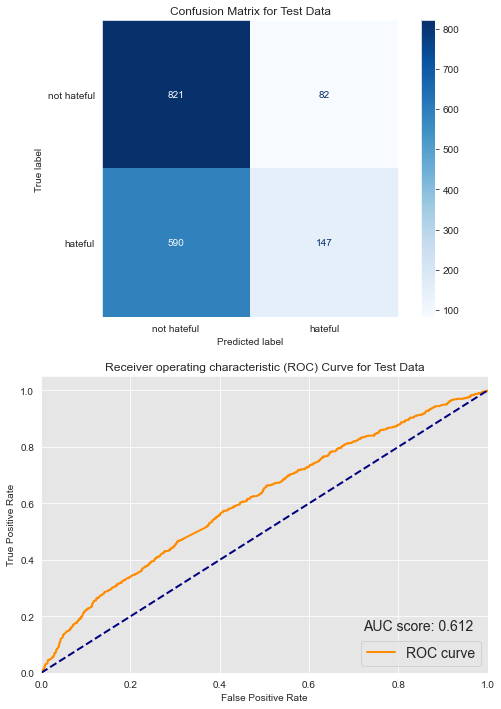

In [28]:
# evaluate model on train and test
evaluate(tfidf_gs, X_train, y_train, X_test, y_test, grid_search=True)

This tuned multinomial Naive Bayes classifier based on tf-idf vectorization is comparable in some respects to the tuned multinomial Naive Bayes classifier based on count vectorization. Testing accuracy is 59.0% compared 59.8%, testing f1 score is 0.304 compared to 0.449, and ROC-AUC is 0.612 compared to 0.611. Like the boolean-vectorized model, the low f1 score makes this model less attractive than the count-vectorized one.

### GloVe - Logistic Regression

We've achieved some level of improvement over the baseline predictions using a bag-of-words approach. Let's see if using word embeddings will offer performance improvements. We'll calculate embeddings for each token we can in the meme text and then average these to obtain a mean embedding vector for each meme. Then, we'll use these features in a logistic regression model.

In [29]:
# pipeline of tokenizer, vectorizer, and classifier
glove_lr = Pipeline([('token', W2vTokenizer(glove)),
                     ('vect', W2vVectorizer(glove)),
                     ('scaler', StandardScaler()),
                     ('clf', LogisticRegression(solver='saga', max_iter=1000, random_state=42))])

In [30]:
# parameter grid
glovelr_grid = {
    "clf__penalty": ['elasticnet'],
    "clf__l1_ratio": (0, 0.5, 1),
    "clf__C": (1.0, 0.1, 1e-2, 1e-3)
}

# refit on roc_auc
glovelr_gs = GridSearchCV(estimator=glove_lr, param_grid=glovelr_grid, scoring=scoring_metrics, refit='roc_auc', n_jobs=-1)

# fit on train
glovelr_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('token',
                                        <utils.W2vTokenizer object at 0x00000210485B2640>),
                                       ('vect',
                                        <utils.W2vVectorizer object at 0x00000210485B26A0>),
                                       ('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'clf__C': (1.0, 0.1, 0.01, 0.001),
                         'clf__l1_ratio': (0, 0.5, 1),
                         'clf__penalty': ['elasticnet']},
             refit='roc_auc', scoring=('accuracy', 'f1', 'roc_auc'))

Training Metrics
Accuracy: 0.682
Precision: 0.642
Recall: 0.233
f1: 0.342
----------
Testing Metrics
Accuracy: 0.562
Precision: 0.546
Recall: 0.153
f1: 0.239

Best Parameters
{'clf__C': 0.001, 'clf__l1_ratio': 0, 'clf__penalty': 'elasticnet'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__l1_ratio,param_clf__penalty,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
9,2.736816,0.243438,0.954585,0.141337,0.001,0,elasticnet,"{'clf__C': 0.001, 'clf__l1_ratio': 0, 'clf__pe...",0.670000,0.665882,0.674118,0.657059,0.682353,0.669882,0.008413,7,0.297872,0.325416,0.302267,0.272160,0.354067,0.310356,0.027632,8,0.724693,0.679286,0.668151,0.654345,0.746980,0.694691,0.035224,1
6,8.564193,0.521766,1.693696,0.222053,0.01,0,elasticnet,"{'clf__C': 0.01, 'clf__l1_ratio': 0, 'clf__pen...",0.684706,0.665882,0.666471,0.650588,0.685294,0.670588,0.013074,4,0.393665,0.395745,0.369299,0.332584,0.414020,0.381063,0.028104,6,0.714561,0.681268,0.670096,0.654424,0.735762,0.691222,0.029759,2
4,25.486756,2.500093,1.460919,0.129528,0.1,0.5,elasticnet,"{'clf__C': 0.1, 'clf__l1_ratio': 0.5, 'clf__pe...",0.682353,0.662353,0.668235,0.650000,0.684118,0.669412,0.012742,8,0.394619,0.397059,0.385621,0.336678,0.415669,0.385929,0.026494,5,0.712663,0.680185,0.668160,0.653282,0.734037,0.689665,0.029577,3
5,17.129572,2.278110,1.403370,0.248501,0.1,1,elasticnet,"{'clf__C': 0.1, 'clf__l1_ratio': 1, 'clf__pena...",0.682353,0.667059,0.668235,0.651765,0.684706,0.670824,0.011914,3,0.380734,0.380744,0.363431,0.325740,0.403118,0.370753,0.025794,7,0.714297,0.679286,0.666585,0.651895,0.735269,0.689466,0.030832,4
3,23.609817,1.994331,1.393106,0.326291,0.1,0,elasticnet,"{'clf__C': 0.1, 'clf__l1_ratio': 0, 'clf__pena...",0.677647,0.670000,0.666471,0.653529,0.688824,0.671294,0.011732,2,0.408207,0.423433,0.394877,0.363243,0.444911,0.406934,0.027460,4,0.710264,0.679247,0.668434,0.653360,0.731244,0.688510,0.028368,5
2,57.585640,7.354389,1.446458,0.298832,1,1,elasticnet,"{'clf__C': 1.0, 'clf__l1_ratio': 1, 'clf__pena...",0.676471,0.671765,0.664706,0.653529,0.691765,0.671647,0.012684,1,0.408602,0.428279,0.392324,0.367347,0.455301,0.410371,0.030064,3,0.709036,0.679078,0.667401,0.652857,0.730868,0.687848,0.028352,6
1,67.131464,7.218029,1.404706,0.318620,1,0.5,elasticnet,"{'clf__C': 1.0, 'clf__l1_ratio': 0.5, 'clf__pe...",0.677059,0.668824,0.664706,0.651176,0.690588,0.670471,0.013087,6,0.412834,0.427263,0.391026,0.371156,0.455487,0.411553,0.029093,2,0.708427,0.677283,0.667200,0.652282,0.729220,0.686882,0.028048,7
7,6.170237,0.194416,1.407367,0.309450,0.01,0.5,elasticnet,"{'clf__C': 0.01, 'clf__l1_ratio': 0.5, 'clf__p...",0.665882,0.664118,0.662353,0.654706,0.678824,0.665176,0.007816,9,0.248677,0.292441,0.256477,0.256020,0.310606,0.272844,0.024269,9,0.720604,0.667940,0.653716,0.652946,0.738349,0.686711,0.035767,8
0,43.084588,2.728088,1.268923,0.036596,1,0,elasticnet,"{'clf__C': 1.0, 'clf__l1_ratio': 0, 'clf__pena...",0.678235,0.669412,0.663529,0.651176,0.690588,0.670588,0.013315,5,0.414973,0.428862,0.391489,0.372487,0.456612,0.412885,0.029194,1,0.706968,0.675204,0.666893,0.650703,0.727583,0.685470,0.027910,9
8,4.187588,0.391285,1.124546,0.092331,0.01,1,elasticnet,"{'clf__C': 0.01, 'clf__l1_ratio': 1, 'clf__pen...",0.658824,0.654118,0.651176,0.647647,0.660588,0.654471,0.004773,10,0.183099,0.203252,0.177531,0.191633,0.188467,0.188796,0.008677,10,0.703985,0.656231,0.637155,0.635490,0.727206,0.672014,0.037058,10


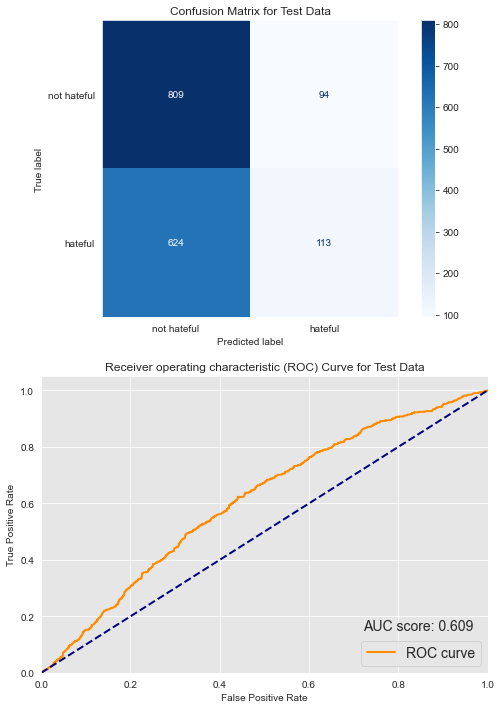

In [31]:
# evaluate model on train and test
evaluate(glovelr_gs, X_train, y_train, X_test, y_test, grid_search=True)

This logistic regression classifier based on mean 300-dimensional word embeddings is worse compared to the tuned multinomial Naive Bayes classifier based on count vectorization. Testing accuracy is 56.2% compared 59.8%, testing f1 score is 0.239 compared to 0.449, and ROC-AUC is 0.609 compared to 0.611.

A random forest classifier was also ran on these word embeddings with similarly poor performance. You can find the results in [this notebook](https://github.com/andrewwhitman/HatefulMemesDetection/blob/main/notebooks/Models.ipynb)

## Final Model

The best-performing model according to the combination of accuracy, f1 score, and ROC-AUC has been the tuned multinomial Naive Bayes classifier based on count vectorization. Let's evaluate this "final" model on the holdout set.

Training Metrics
Accuracy: 0.767
Precision: 0.703
Recall: 0.597
f1: 0.646
----------
Testing Metrics
Accuracy: 0.614
Precision: 0.478
Recall: 0.331
f1: 0.391

Best Parameters
{'clf__alpha': 1, 'vect__max_df': 0.25, 'vect__max_features': 2000, 'vect__ngram_range': (1, 1), 'vect__stop_words': None}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,param_vect__max_df,param_vect__max_features,param_vect__ngram_range,param_vect__stop_words,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
16,0.192409,0.005307,0.087487,7.659857e-03,1,0.25,2000,"(1, 1)",None,"{'clf__alpha': 1, 'vect__max_df': 0.25, 'vect_...",0.713529,0.658824,0.686471,0.682353,0.718235,0.691882,0.021799,17,0.551152,0.471767,0.508756,0.506399,0.573464,0.522307,0.035889,46,0.716463,0.671462,0.693277,0.699577,0.730740,0.702304,0.020245,1
28,0.204232,0.014613,0.088915,1.140937e-02,1,0.1,2000,"(1, 1)",None,"{'clf__alpha': 1, 'vect__max_df': 0.1, 'vect__...",0.712353,0.660588,0.690588,0.684706,0.710588,0.691765,0.018981,18,0.550964,0.478771,0.515654,0.509158,0.565371,0.523984,0.030901,41,0.716412,0.671851,0.695928,0.695683,0.731382,0.702251,0.020280,2
4,0.194338,0.014504,0.086706,9.640574e-03,1,0.5,2000,"(1, 1)",None,"{'clf__alpha': 1, 'vect__max_df': 0.5, 'vect__...",0.712941,0.663529,0.683529,0.685882,0.715882,0.692353,0.019637,16,0.552294,0.479053,0.506422,0.514545,0.569902,0.524443,0.032635,39,0.720067,0.669204,0.694798,0.694303,0.729299,0.701534,0.021247,3
17,0.168709,0.006247,0.092959,4.267687e-03,1,0.25,2000,"(1, 1)",english,"{'clf__alpha': 1, 'vect__max_df': 0.25, 'vect_...",0.718824,0.664118,0.688235,0.687059,0.704706,0.692588,0.018413,12,0.567812,0.490633,0.514652,0.515483,0.555752,0.528866,0.028575,15,0.713720,0.673423,0.692264,0.697899,0.729506,0.701362,0.019079,4
5,0.192205,0.010829,0.085632,1.033355e-02,1,0.5,2000,"(1, 1)",english,"{'clf__alpha': 1, 'vect__max_df': 0.5, 'vect__...",0.718824,0.664118,0.688235,0.687059,0.704706,0.692588,0.018413,12,0.567812,0.490633,0.514652,0.515483,0.555752,0.528866,0.028575,15,0.713720,0.673423,0.692264,0.697899,0.729506,0.701362,0.019079,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,0.386137,0.023745,0.124969,6.031566e-07,0.1,0.25,None,"(1, 2)",english,"{'clf__alpha': 0.1, 'vect__max_df': 0.25, 'vec...",0.633529,0.631176,0.635294,0.620588,0.651176,0.634353,0.009840,67,0.515175,0.514330,0.509494,0.482759,0.533438,0.511039,0.016321,58,0.625151,0.610827,0.616557,0.607384,0.642193,0.620422,0.012436,67
39,0.426092,0.021404,0.131453,1.604584e-02,0.1,0.5,None,"(1, 2)",english,"{'clf__alpha': 0.1, 'vect__max_df': 0.5, 'vect...",0.633529,0.631176,0.635294,0.620588,0.651176,0.634353,0.009840,67,0.515175,0.514330,0.509494,0.482759,0.533438,0.511039,0.016321,58,0.625151,0.610827,0.616557,0.607384,0.642193,0.620422,0.012436,67
38,0.576602,0.013294,0.180978,3.098648e-02,0.1,0.5,None,"(1, 2)",None,"{'clf__alpha': 0.1, 'vect__max_df': 0.5, 'vect...",0.639412,0.624706,0.631765,0.612353,0.629412,0.627529,0.008955,71,0.519216,0.485484,0.495974,0.468119,0.503937,0.494546,0.017201,69,0.627859,0.606055,0.617266,0.605621,0.627678,0.616896,0.009810,70
50,0.542706,0.021190,0.162459,7.652942e-03,0.1,0.25,None,"(1, 2)",None,"{'clf__alpha': 0.1, 'vect__max_df': 0.25, 'vec...",0.638235,0.625882,0.632941,0.610000,0.629412,0.627294,0.009562,72,0.519156,0.487923,0.497585,0.465753,0.503937,0.494871,0.017751,68,0.627410,0.605972,0.617072,0.605707,0.627406,0.616713,0.009648,71


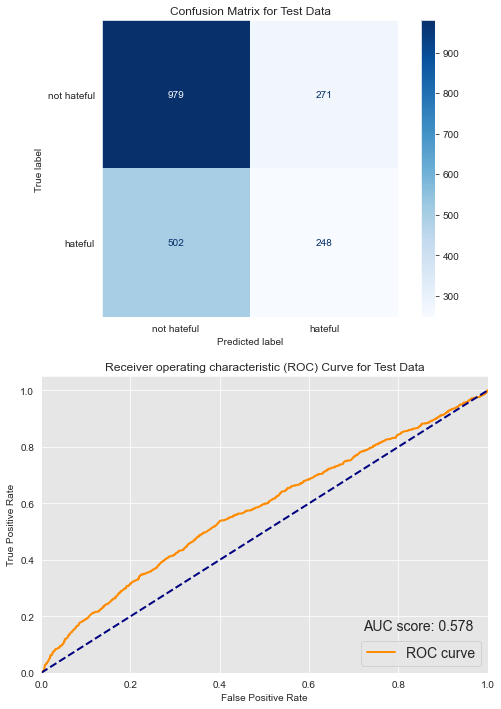

In [32]:
evaluate(count_gs, X_train, y_train, X_hold, y_hold, grid_search=True)

This tuned multinomial Naive Bayes classifier based on count vectorization has the following metrics of interest on the holdout set: accuracy is 61.4%, f1 score is 0.391, and ROC-AUC is 0.578. The model appears to be overfit based on the divergence between training and holdout metrics. However, performance on the holdout set is similar to performance on the test set, which lends some evidence to the model's generalizability.

This textual bag-of-words approach has definite limitations in classifying hateful memes. First, it is known that the visual content is important for correctly classifying the meme, yet the model only considers the text of the meme. Second, the bag-of-words approach only considers word occurences, not order, in deriving any semantic meaning associated with hateful meme text. Third, this final model only uses a vocabulary size of 2000, meaning many words are discarded in vectorizing meme text.

## Conclusions

The predictions from the final model could be used in a few ways in a content moderation system. One approach would be to automatically tag content with memes predicted as hateful with a content warning message and to blur the memes. This would allow the content to stay up, but would provide barriers to people seeing the content. Since the model's precision is 48% on holdout data, about half the blurred memes wouldn't be actually hateful.

In addition to a warning and blur, a team could manually review the memes the model has predicted as hateful beginning with the most likely. The workload would be reduced from all memes to only this subset, albeit still a large subset. If a meme truly is hateful, this content could be removed. If not, the warning and blur could be removed to restore the content. 

A different, more aggressive approach would be to automatically remove all content with memes predicted as hateful by the final model. This strategy could rely upon a review team as well. They would resolve any appeals of removed content. A risk associated here is frustrating users since about half of the final model predictions of hateful memes will be false positives.

Lastly, the final model's decision boundary could be tuned to an appropriate setting along the ROC curve according to a business's specific content moderation goals and values.

As noted in the evaluation of the final model, this project does not fully solve the business problem of classifying memes as hateful or not-hateful. Future work below lays out ideas for improvement.

### Future Work
<a id='future_work'></a>

With the limitations of the final model, one next step is to use unsupervised object detection to incorporate the visual component of the memes. This output could be combined with textual representations to provide a multimodal solution.

In addition, incorporating optical character recognition for text extraction would make the system more complete for use on future memes.

Using advanced language models such as state-of-the-art pre-trained transformer-based models like BERT could provide performance improvements on the textual content of the memes.

In terms of data, using memes containing languages other than English would be a worthwhile next step. This would require similar steps as taken by Facebook AI to curate a new meme dataset.